## Create and Run MCNP simulations - Windows version

The worm script must be run seperately in Cygwin using the command

\>\>perl worm HPGe_model

From the FinalModel folder.  The the runMCNP.bat can be run from the same directory:

\>\> runMCNP.bat

In [1]:
from GeneralNuclear.MCNP import batchmaker
from subprocess import Popen

batchmaker('ValidationSimulations/', inputSuffix="in", tasks=2)

Skipping file: HPGe_model
Skipping file: HPGe_model_1_1_1.o
Skipping file: HPGe_model_1_1_18.o
Skipping file: HPGe_model_1_1_5.o
Skipping file: HPGe_model_1_2_1.o
Skipping file: HPGe_model_1_2_18.o
Skipping file: HPGe_model_1_2_5.o
Skipping file: HPGe_model_1_3_1.o
Skipping file: HPGe_model_1_3_18.o
Skipping file: HPGe_model_1_3_5.o
Skipping file: HPGe_model_1_4_1.o
Skipping file: HPGe_model_1_4_18.o
Skipping file: HPGe_model_1_4_5.o
Skipping file: HPGe_model_1_5_1.o
Skipping file: HPGe_model_1_5_18.o
Skipping file: HPGe_model_1_5_5.o
Skipping file: HPGe_model_2_1_1.o
Skipping file: HPGe_model_2_1_18.o
Skipping file: HPGe_model_2_1_5.o
Skipping file: HPGe_model_2_2_1.o
Skipping file: HPGe_model_2_2_18.o
Skipping file: HPGe_model_2_2_5.o
Skipping file: HPGe_model_2_3_1.o
Skipping file: HPGe_model_2_3_18.o
Skipping file: HPGe_model_2_3_5.o
Skipping file: HPGe_model_2_4_1.o
Skipping file: HPGe_model_2_4_18.o
Skipping file: HPGe_model_2_4_5.o
Skipping file: HPGe_model_2_5_1.o
Skipping file

## Create and Run MCNP simulations

The following cell works on linux (but hasn't been tested)

from GeneralNuclear.MCNP import batchmaker
from subprocess import Popen

Popen('perl ValidationSimulations/worm Final/HPGe_model')
batchmaker('ValidationSimulations/', inputSuffix="in", scriptType='sh')
Popen('./ ValidationSimulations/runMCNP.sh')

## Read and Store the Tally Results


In [2]:
import os
import pandas as pd
from GeneralNuclear.MCNP import read_tally

# Energy index map (from worm input)
energy = [59.54, 661.657]
x = [-2.5, 0, 2.5, 0, 0] 
y = [0, 2.5, 0, -2.5, 0] 

# Create dataframe
model = pd.DataFrame(columns=['energy', 'x', 'y', 'z', 'modelEff', 'modelSigma'], dtype=float)

for filename in os.listdir('ValidationSimulations/'):
    splitFile = filename.split('.')
    if splitFile[-1] == 'o':
        print filename
        splitFile = filename.split('_')
        tmpTally = read_tally('ValidationSimulations/'+filename, 8, readGroups=True)[0]
        
        # Loop over tally to find the data corresponding to the peak and store
        for index, row in tmpTally.iterrows():
            if float(row[0]) > energy[int(splitFile[2])-1]/1000.:
                tally = float(row[1])
                uncert = float(row[2])
                break
                
        model = model.append(pd.Series([energy[int(splitFile[2])-1], x[int(splitFile[3])-1], y[int(splitFile[3])-1], 
                                        float(splitFile[4].split('.')[0]), tally, tally*uncert], 
                                       index=['energy', 'x', 'y', 'z', 'modelEff', 'modelSigma']), ignore_index=True)

print model

HPGe_model_1_1_1.o
HPGe_model_1_1_18.o
HPGe_model_1_1_5.o
HPGe_model_1_2_1.o
HPGe_model_1_2_18.o
HPGe_model_1_2_5.o
HPGe_model_1_3_1.o
HPGe_model_1_3_18.o
HPGe_model_1_3_5.o
HPGe_model_1_4_1.o
HPGe_model_1_4_18.o
HPGe_model_1_4_5.o
HPGe_model_1_5_1.o
HPGe_model_1_5_18.o
HPGe_model_1_5_5.o
HPGe_model_2_1_1.o
HPGe_model_2_1_18.o
HPGe_model_2_1_5.o
HPGe_model_2_2_1.o
HPGe_model_2_2_18.o
HPGe_model_2_2_5.o
HPGe_model_2_3_1.o
HPGe_model_2_3_18.o
HPGe_model_2_3_5.o
HPGe_model_2_4_1.o
HPGe_model_2_4_18.o
HPGe_model_2_4_5.o
HPGe_model_2_5_1.o
HPGe_model_2_5_18.o
HPGe_model_2_5_5.o
     energy    x    y     z  modelEff  modelSigma
0    59.540 -2.5  0.0   1.0  0.123630    0.001038
1    59.540 -2.5  0.0  18.0  0.005291    0.000054
2    59.540 -2.5  0.0   5.0  0.039054    0.000273
3    59.540  0.0  2.5   1.0  0.122660    0.001043
4    59.540  0.0  2.5  18.0  0.005283    0.000054
5    59.540  0.0  2.5   5.0  0.038588    0.000274
6    59.540  2.5  0.0   1.0  0.122120    0.001038
7    59.540  2.5  0.

## Read Experimental Data Results

In [3]:
import pandas as pd

# Create dataframe
data = pd.DataFrame(columns=['energy', 'x', 'y', 'z', 'expEff', 'expSigma', 'modelEff', 'modelSigma'], dtype=float)
data = pd.read_excel('ValidationData.xlsx', parse_cols='A,B,C,D,Q,R',
                     names=['energy', 'x', 'y', 'z', 'expEff', 'expSigma'])

# Match data points and combine into one dataframe
for i in range(len(model)):
    for j in range(len(data)):
        if all(model.ix[i, 0:4] == data.ix[j, 0:4]):
            data.ix[j, 'modelEff'] = model.ix[i, 'modelEff']
            data.ix[j, 'modelSigma'] = model.ix[i, 'modelSigma']
            break
            
data.sort_values('energy', inplace=True)
print data

C:\Users\James\Anaconda2\lib\site-packages\ipykernel_launcher.py:11: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  # This is added back by InteractiveShellApp.init_path()


     energy    x    y   z    expEff  expSigma  modelEff  modelSigma
29   59.540  0.0  2.5   1  0.123795  0.001463  0.122660    0.001043
27   59.540 -2.5  0.0   1  0.124735  0.001474  0.123630    0.001038
26   59.540  0.0  0.0   1  0.172887  0.002041  0.174120    0.001201
25   59.540  0.0 -2.5   1  0.126024  0.001489  0.122810    0.001044
24   59.540  0.0  2.5   5  0.038460  0.000458  0.038588    0.000274
23   59.540  2.5  0.0   5  0.037633  0.000449  0.038412    0.000273
22   59.540 -2.5  0.0   5  0.037525  0.000447  0.039054    0.000273
21   59.540  0.0  0.0   5  0.043382  0.000516  0.046476    0.000297
20   59.540  0.0 -2.5   5  0.037092  0.000442  0.038600    0.000274
19   59.540  0.0  2.5  18  0.005505  0.000076  0.005283    0.000054
18   59.540  2.5  0.0  18  0.005539  0.000076  0.005271    0.000054
17   59.540 -2.5  0.0  18  0.005314  0.000073  0.005291    0.000054
16   59.540  0.0  0.0  18  0.005751  0.000079  0.005437    0.000055
15   59.540  0.0 -2.5  18  0.005468  0.000075  0

## Plot the Results

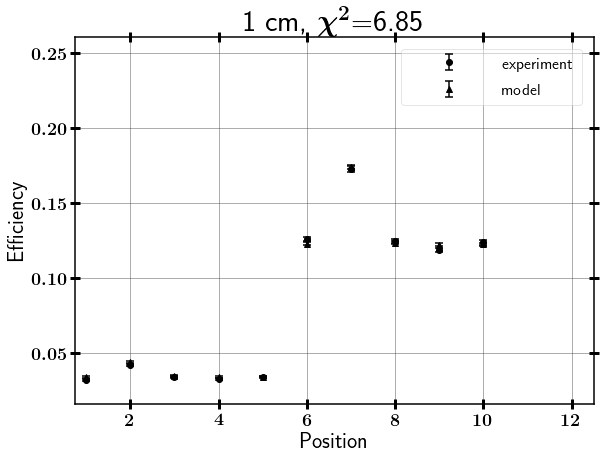

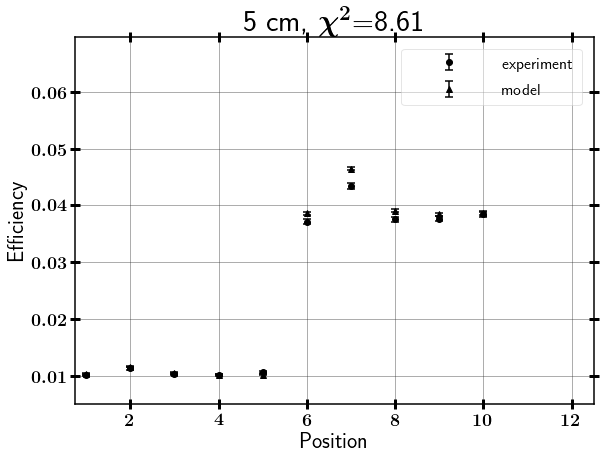

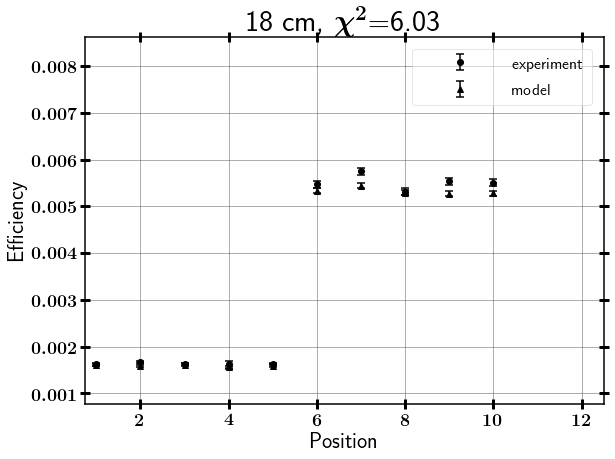

In [4]:
import matplotlib
matplotlib.use('Qt5Agg')
%matplotlib inline

from Support.Plotting import plot
from DataAnalysis.Stats import red_chisq

shelfPoints = 10
numShelves = 3
shelves = [1, 5, 18]

for s in shelves:
    xData, yData, expSig, yMod, modSig = [], [], [], [], []
    for i in range(len(data)):
        if data.at[i, 'z'] == s:
            xData.append(len(xData)+1)
            yData.append(data.at[i, 'expEff'])
            yMod.append(data.at[i, 'modelEff'])
            expSig.append(data.at[i, 'expSigma'])
            modSig.append(data.at[i, 'modelSigma'])
    redChi2 = red_chisq(yData, yMod, standDev=expSig, freeParams=1)
    plot([xData, yData, expSig], [xData, yMod, modSig], dataLabel=['experiment', 'model'], includeLines=False,
          xLabel='Position', yLabel='Efficiency', title='{} cm, $\chi^2$={:3.2f}'.format(s, redChi2))